

# Clasificación de géneros musicales mediante el uso de la base de datos GTZAN Dataset. Parte 1 ( Vizualización de datos y creación del archivo JSON ) 

Estudiante: Andrés Camilo Salazar Palacios

Profesor: Diego Fabian Collazos Huertas

Universidad Nacional de Colombia sede Manizales - Analítica de datos.


 * [GTZAN Dataset on Kaggle](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification)  - Music Genre Classification, se obtuvo a travez de Kaggle, para la detección del genero musical a partir de un archivo de audio de entrada. Las caracteristicas del modelo, la base de datos y el tratamiento de los mismos para la clasificación y detección de generos musicales se muestran a continuación.

In [ ]:
# Importamos las librerias necesarias para nuestro proyecto. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import librosa
import os
import IPython.display as ipd
import librosa.display
import re
import json
import math


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Lo que viene a continuación en el desarrollo de este Notebook, es cargar la base de datos creada a partir de archivos de audio en formato WAV, cuya duración es de 30 segundos, a partir de esto realizar un análisis espectral de todos los archivos de audio, de manera que, una vez hecho esto, nuestro siguiente paso es la obtención de los espectrogramas de Mel de cada audio, lo que nos permitiría exportarlos como archivos de imagen, y así realizar nuestro modelo con base en la clasificación de imágenes a partir de archivos de audio. Imágenes que como veremos en el desarrollo de este proyecto y dependiendo del género musical tendrán algunas características que son notables al ojo humano y esto nos permitirá un mayor entendimiento a cerca del funcionamiento de las redes neuronales.

In [ ]:

#librerias para proceso
from pandas.core.indexes.datetimes import date
from pandas.io.formats.style_render import DataFrame
from pandas.core.groupby.groupby import DataError
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
path = '/content/drive/My Drive/PAD/Data'
datafolderload = '/content/drive/My Drive/PAD/Data01/genres_original'
dataset1 = pd.read_csv('/content/drive/My Drive/PAD/Data/features_30_sec.csv')


In [ ]:
dataset1.shape # Verificamos la cantidad de datos de los archivos para su posterior concatenación. 

(1000, 60)

In [ ]:
dataset1.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
# Usaremos un de las canciones de la base de datos para mostrar como se obtiene el espectograma de MEL. 
example_file1 = '/content/drive/My Drive/PAD/Data01/genres_original/metal/metal.00004.wav'
signal1, sample_rate = librosa.load(example_file1)
sample_rate


22050

Text(0.5, 1.0, 'waveform')

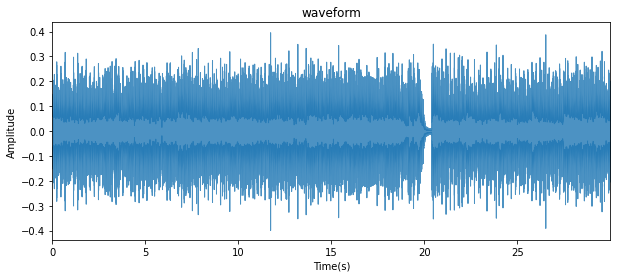

In [ ]:
# Configuramos los àrametros de la grafica en tiempo de nuestra canción.
size=(10,4)
plt.figure(figsize=size)
librosa.display.waveplot(signal1,sample_rate,alpha=0.8)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("waveform")


Text(0.5, 1.0, 'Power Spectrum wav')

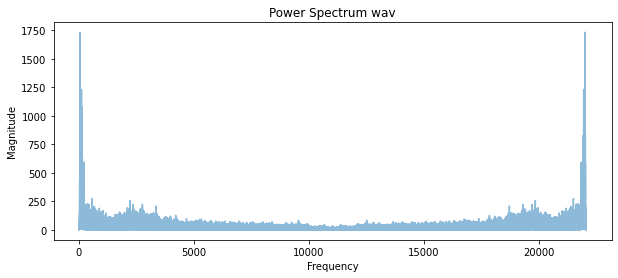

In [ ]:
# Fourier Transform (FFT) - Frequency Domain
fft = np.fft.fft(signal1)
# Calculamos la magnitud (abs values on complex numbers)
spectrum1 = np.abs(fft)
# Creamos la variable de frecuencia.
f = np.linspace(0, sample_rate, len(spectrum1))
# Plot Spectrum
plt.figure(figsize=size)
plt.plot(f, spectrum1, alpha=0.5)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power Spectrum wav")


Text(0.5, 1.0, 'Power Spectrum WAV')

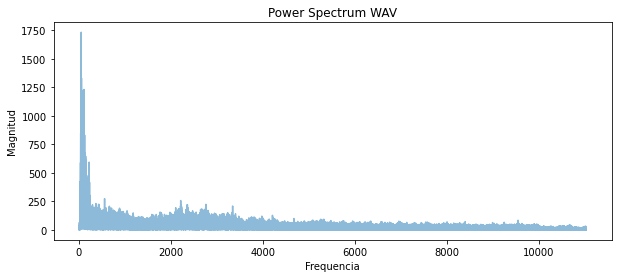

In [ ]:
left_spectrum = spectrum1[:int(len(spectrum1)/2)]
left_f = f[:int(len(spectrum1)/2)]
##
# Plot Spectrum
plt.figure(figsize=size)
plt.plot(left_f, left_spectrum, alpha=0.5)
plt.xlabel("Frequencia")
plt.ylabel("Magnitud")
plt.title("Power Spectrum WAV")

Text(0.5, 1.0, 'Spectrograma')

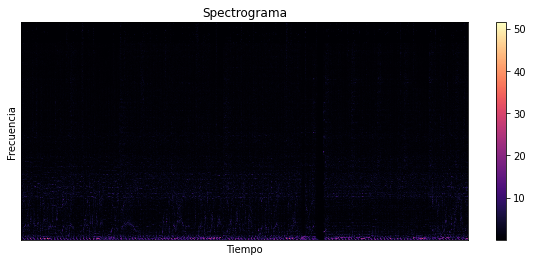

In [ ]:
#Ahora vamos aver el spectrograma a travez de la STFT
hop_length = 512 #Numero de Muestras (Dimension de la ventana)
n_fft = 2048 #Resolucion o número de muestras por ventana. 
stft = librosa.stft (signal1, n_fft=n_fft, hop_length=hop_length)
# Calculamos la magnitud. abs
espectrograma = np.abs(stft)

# Pasos para mostrar el espectrograma:
# en el se nos muestra los cambios en frecencia a travez del tiempo:
plt.figure(figsize=size)
librosa.display.specshow(espectrograma, sr=sample_rate,hop_length=hop_length)
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.colorbar()
plt.title("Spectrograma") #Esto nos muestra la magnitud de la frecuencia.

Text(0.5, 1.0, 'Spectrograma (dB)')

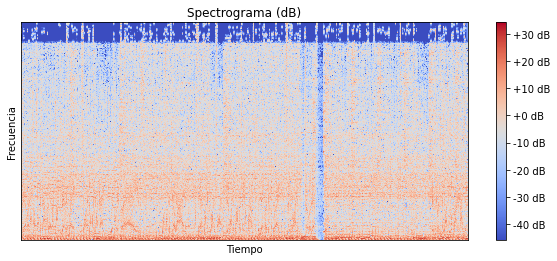

In [ ]:
#Podemos ver el anterior espectrograma pero en escala logaritmica, es decir en db, tal como se muestra convencionalmente el sonido:
espectrograma_log = librosa.amplitude_to_db(espectrograma)
# Y lo mostramos.
plt.figure(figsize=size)
librosa.display.specshow(espectrograma_log, sr=sample_rate,hop_length=hop_length)
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrograma (dB)") #Esto nos muestra la magnitud de la frecuencia ahora en Decibeles.


Text(0.5, 1.0, 'MFCCs')

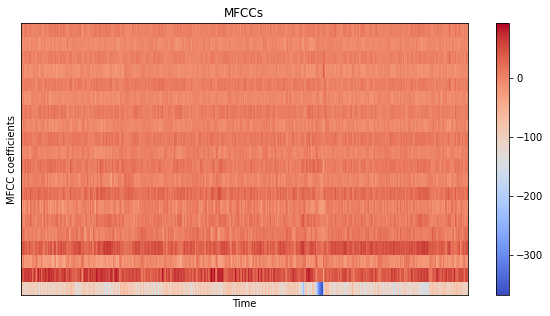

In [ ]:
# Finalmente podemos obtener los coeficientes de Mel. Usaremos 20 coeficientes.
MELFCC = librosa.feature.mfcc(signal1, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=20 )
# Plot MFCCs
plt.figure(figsize= (10,5))
librosa.display.specshow(MELFCC, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

In [ ]:
dataset_path1 = "/content/drive/MyDrive/PAD/Data01/genres_original"
JSON_PATH = "/content/drive/My Drive/PAD/Nuevo_115.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
def save_mfcc(dataset_path1, json_path, num_mfcc=20, n_fft=2048, hop_length=512, num_segments=5):
    """Extraermos los coeficientes de mel y los guarda en un archivo json, con el respectivo orden de cada genero.
        """

    # Creamos un diccionario para el mapeo,los labels, y MFCCs
    data = {
        "mapping": [], #Nombres de los generos.
        "labels": [], # de 0 a 9 son 10 generos.
        "mfcc": [] # Listas con 15 coeficietenes de Mel por cada canción.
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop para recorer todas las carpetas. 
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path1)):

        # verificacion
        if dirpath is not dataset_path1:

            # guardamos el label de cada genero en la lista mapping.
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # procesa cada archivo de audio.
            for f in filenames:

		# carga los audios
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # procesa todos los segmentos de los archivos de audio
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extraemos los mfcc 
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
import warnings #eliminar warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
!apt install ffmpeg
#Ejecutamos la funcion save_mfcc, para crear el archivo json
save_mfcc(dataset_path1, JSON_PATH, num_segments=25)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment:3
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment:4
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment:5
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment:6
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment:7
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment:8
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment:9
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment:10
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment:11
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment:12
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment:13
/content/drive/MyDrive/PAD/Data01/genres_original/pop/pop.00000.wav, segment

In [ ]:
orr_matrix = dataset1.corr()
orr_matrix.style.background_gradient(cmap='coolwarm')

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
length,1.000000,0.017426,0.073979,0.101801,0.116661,0.052175,0.121994,0.062503,0.118993,0.040363,0.106346,0.025562,0.113593,0.022029,0.109892,-0.046251,0.077283,0.060316,0.054666,0.127369,-0.086796,0.136095,0.058542,0.085642,-0.114049,0.081549,0.105022,0.062592,-0.121300,0.089809,0.114826,0.060114,-0.083152,0.096725,0.114684,0.054959,-0.052095,0.057638,0.168307,0.051005,-0.043836,0.084516,0.142020,0.038884,-0.059199,0.005673,0.110454,0.023164,-0.019677,0.025483,0.039179,0.003457,-0.025331,0.014822,0.010576,0.045884,0.014803,0.050338
chroma_stft_mean,0.017426,1.000000,-0.461729,0.499926,0.261544,0.615728,0.285926,0.517710,0.041088,0.598122,0.117139,0.554771,0.355920,0.031963,0.281150,-0.116567,0.465995,0.018477,0.659550,-0.125173,-0.598713,-0.052177,-0.054353,0.003765,0.264147,0.132253,-0.010085,0.038402,0.416877,0.101364,0.067508,0.066712,0.509776,-0.026696,0.116040,-0.151147,0.489229,-0.192695,0.072779,-0.301768,0.516690,-0.408530,-0.081445,-0.438212,0.417091,-0.444702,-0.143372,-0.440796,0.332359,-0.452955,-0.163474,-0.456298,0.269935,-0.478452,-0.089509,-0.501768,0.281965,-0.548577
chroma_stft_var,0.073979,-0.461729,1.000000,-0.078777,0.290138,-0.246441,0.305819,-0.036896,0.346907,-0.168721,0.383134,-0.470186,0.169289,-0.006378,0.047447,0.086584,0.020981,-0.079209,-0.343372,0.367570,0.118888,0.353811,0.412857,0.421817,-0.252334,0.394627,0.354068,0.414076,-0.209684,0.447260,0.277560,0.433032,-0.318189,0.450482,0.206969,0.469733,-0.292359,0.421070,0.231738,0.395838,-0.359185,0.382765,0.314236,0.383944,-0.275502,0.365766,0.273446,0.372656,-0.311178,0.361752,0.205117,0.389468,-0.239597,0.378200,0.184323,0.365291,-0.231715,0.333581
rms_mean,0.101801,0.499926,-0.078777,1.000000,0.607399,0.510154,0.324077,0.530017,0.099830,0.537902,0.200083,0.332163,0.319304,0.064440,0.893898,-0.009166,0.789994,-0.052634,0.807239,-0.179467,-0.484057,-0.009069,0.139513,-0.024116,0.008731,0.180446,0.108939,0.068321,0.125682,0.213669,0.167750,0.114015,0.178947,0.083730,0.216109,0.011487,0.186127,-0.005768,0.117318,-0.118258,0.183280,-0.195578,0.013036,-0.236572,0.163009,-0.216350,-0.011154,-0.214653,0.083936,-0.160347,-0.029562,-0.163490,0.118239,-0.164834,0.031297,-0.207680,0.124413,-0.252434
rms_var,0.116661,0.261544,0.290138,0.607399,1.000000,0.347831,0.583353,0.402333,0.320793,0.368570,0.417880,0.156530,0.568643,0.084849,0.585318,0.123557,0.789910,-0.118671,0.326590,0.276735,-0.368384,0.348277,0.297067,0.351018,-0.234197,0.465319,0.265403,0.359638,-0.155544,0.533171,0.312285,0.357660,-0.126337,0.407201,0.328440,0.329269,-0.071458,0.287186,0.266139,0.180124,-0.077560,0.106692,0.229806,0.099020,-0.037588,0.059604,0.211396,0.062595,-0.093893,0.091863,0.168169,0.100234,-0.002585,0.058050,0.186953,0.049879,0.029364,0.012087
spectral_centroid_mean,0.052175,0.615728,-0.246441,0.510154,0.347831,1.000000,0.520548,0.904435,0.011256,0.979637,0.198031,0.874749,0.671771,0.053695,0.316211,-0.013444,0.559647,-0.025764,0.721006,-0.201153,-0.940180,-0.017894,0.188000,-0.099545,-0.136810,0.153690,0.069132,-0.078022,0.017597,0.171060,0.215637,0.024782,0.134407,0.051892,0.288884,-0.066127,0.192896,-0.069192,0.152689,-0.143950,0.175123,-0.234021,0.051308,-0.220678,0.170910,-0.203427,0.022383,-0.204568,0.153741,-0.180200,0.027473,-0.158666,0.228275,-0.136272,0

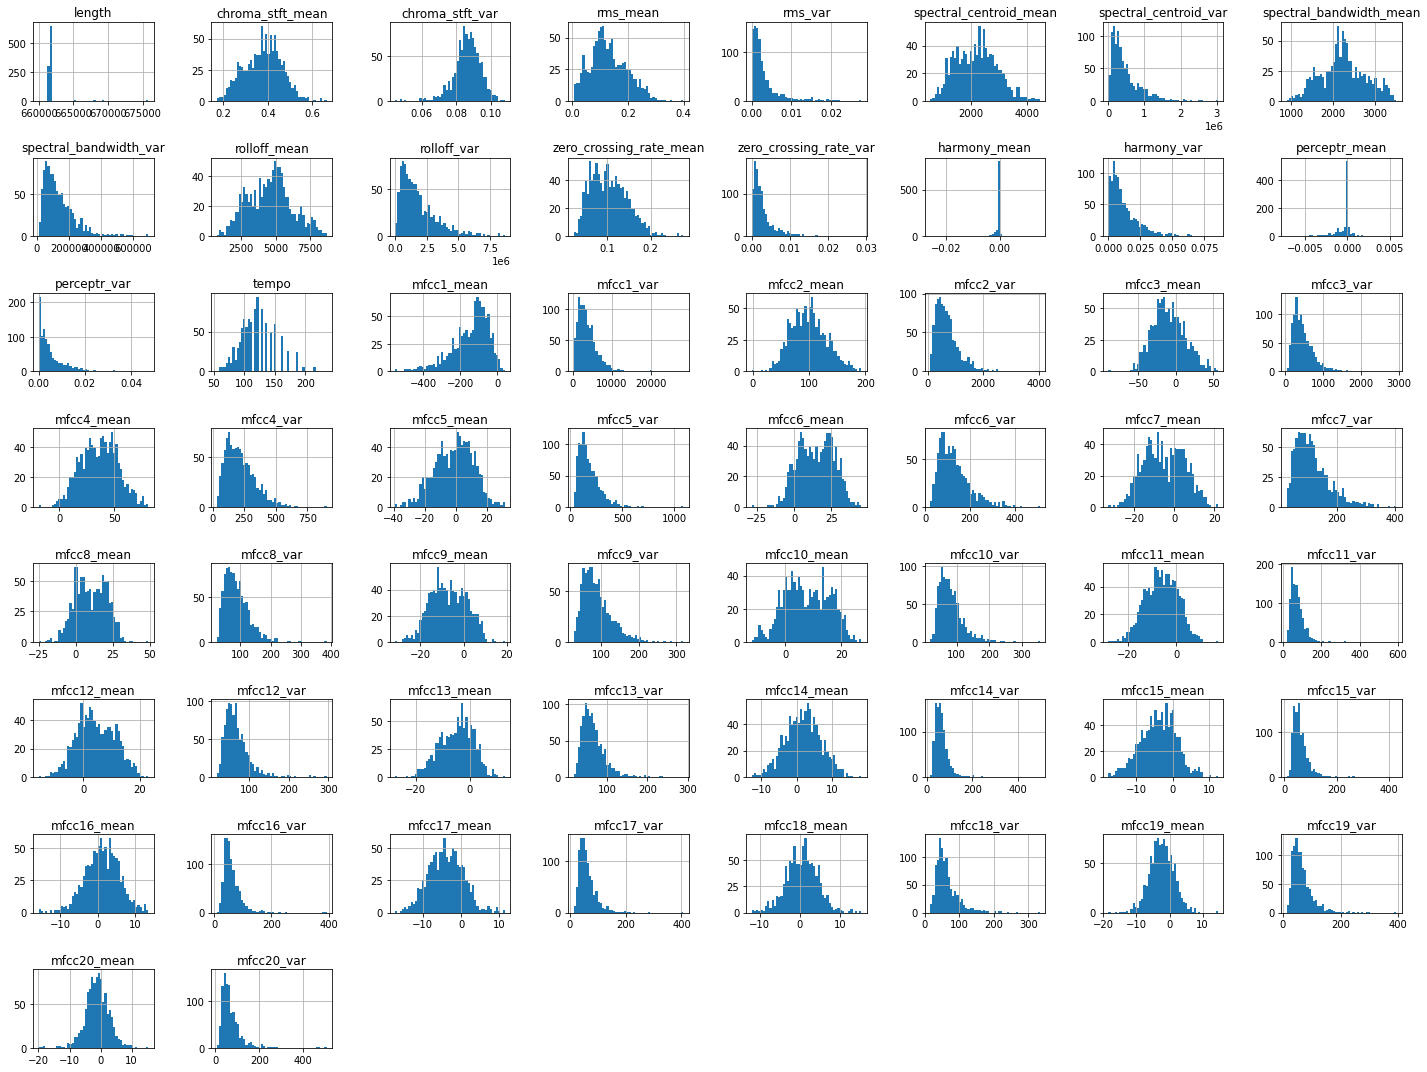

In [ ]:
#Ploteamos los histogramas respecto a las características de nuestros parametros.
import matplotlib.pyplot as plt
dataset1.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.savefig('/content/drive/My Drive/PAD/Data01/attribute_histogram_plots.pdf', format='pdf', dpi=300)#para grabar resultados en pdf
plt.show()